In [91]:
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from skimage.feature import hog
from sympy import sympify
import cv2
import matplotlib.pyplot as plt
import joblib

In [79]:
data_dir = "data"
img_size = 45

# Collect labels
symbol_labels = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])

# Label mappings
symbol_to_index = {label: idx for idx, label in enumerate(symbol_labels)}
index_to_label = {v: k for k, v in symbol_to_index.items()}

X_symbols, y_symbols = [], []

# Load dataset images
for label in symbol_labels:
    folder_path = os.path.join(data_dir, label)
    for file in os.listdir(folder_path):
        if file.endswith(".jpg"):
            try:
                img_path = os.path.join(folder_path, file)
                img = load_img(img_path, color_mode="grayscale", target_size=(img_size, img_size))
                img = img_to_array(img) / 255.0
                X_symbols.append(img)
                y_symbols.append(symbol_to_index[label])
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

# Convert to numpy arrays
X_all = np.array(X_symbols)
y_all = np.array(y_symbols)

print("Dataset loaded:", X_all.shape, y_all.shape)
print("Classes:", index_to_label)

Dataset loaded: (234641, 45, 45, 1) (234641,)
Classes: {0: '!', 1: '(', 2: ')', 3: '+', 4: ',', 5: '-', 6: '0', 7: '1', 8: '2', 9: '3', 10: '4', 11: '5', 12: '6', 13: '7', 14: '8', 15: '9', 16: 'A', 17: 'cos', 18: 'e', 19: 'i', 20: 'log', 21: 'pi', 22: 'sin', 23: 'sqrt', 24: 'sum', 25: 'tan', 26: 'times'}


In [80]:
# Train/test split
# Train + temp set split
X_train, X_temp, y_train, y_temp = train_test_split(
    X_all, y_all, test_size=0.3, random_state=42, stratify=y_all
)

# Validation + Test split (from temp)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Extract HOG features
def extract_hog_features(images):
    features = []
    for img in images:
        img = img.squeeze()
        hog_feat = hog(
            img,
            orientations=14,
            pixels_per_cell=(3, 3),
            cells_per_block=(2, 2),
            block_norm="L2-Hys"
        )
        features.append(hog_feat)
    return np.array(features)

X_train_hog = extract_hog_features(X_train)
X_val_hog   = extract_hog_features(X_val)
X_test_hog  = extract_hog_features(X_test)

In [81]:
rf_hog = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf_hog.fit(X_train_hog, y_train)

# Evaluate
y_pred_hog = rf_hog.predict(X_test_hog)
cm = confusion_matrix(y_test, y_pred_hog)
print("confusion matrix:", cm)
print("Accuracy:", accuracy_score(y_test, y_pred_hog))
print("\nClassification report:\n",
      classification_report(y_test, y_pred_hog,
                            target_names=[index_to_label[i] for i in sorted(index_to_label)]))

confusion matrix: [[ 195    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0 2137    0    0    1    0    0    6    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0 2151    0    0    0    0    3    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0 3766    0    0    0    1    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    7    0  254    0    0   24    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    1    0    0    0]
 [   0    0    0    1    0 5099    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0 1034    0    0    0    1    0    0    0
     0    0    2    0    0    0    0    0    0    0    0    0    0]
 [

In [97]:
#disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(index_to_label.values()))
#disp.plot(cmap="Blues", values_format="d")
#plt.title("Confusion matrix")
#plt.show()


fig, ax = plt.subplots(figsize=(15, 15))  # adjust as needed
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(index_to_label.values()))
disp.plot(cmap="Blues", values_format="d", ax=ax)

# Title and tick label sizes
plt.title("Confusion Matrix", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Save to file
plt.tight_layout()  # ensures labels don't get cut off
plt.savefig("confusion_matrix.png", dpi=300)  # high-quality image
plt.close()  # close the figure to avoid displaying it in the notebook

In [ ]:
joblib.dump(rf_hog, "models/rf_hog.pkl")

In [ ]:
joblib.dump(index_to_label, "models/index_to_label.pkl")

In [84]:
#rf_hog = joblib.load("models/rf_hog.pkl")

#y_pred = rf_hog.predict(X_test_hog)
#print("Loaded model accuracy:", accuracy_score(y_test, y_pred))

In [85]:
def segment_expression(img_path, img_size=45, show_steps=False):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Threshold (invert so text is white)
    _, thresh = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV)

    kernel = np.ones((2,2), np.uint8)
    proc = cv2.dilate(thresh, kernel, iterations=1)

    # Find contours
    contours, _ = cv2.findContours(proc, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    symbol_imgs = []
    bounding_boxes = []

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)

        # Skip very small contours
        if w < 2 or h < 2:
            continue

        roi = thresh[y:y+h, x:x+w]

        # Add padding to make square
        side = max(w, h)
        square = np.zeros((side, side), dtype=np.uint8)
        square[(side-h)//2:(side-h)//2+h, (side-w)//2:(side-w)//2+w] = roi

        # Resize to 45x45
        roi_resized = cv2.resize(square, (img_size, img_size), interpolation=cv2.INTER_AREA)

        # Normalize
        roi_resized = roi_resized.astype("float32") / 255.0
        roi_resized = np.expand_dims(roi_resized, axis=-1)

        symbol_imgs.append(roi_resized)
        bounding_boxes.append((x, y, w, h))

    # Sort symbols left-to-right
    sorted_symbols = [s for _, s in sorted(zip(bounding_boxes, symbol_imgs), key=lambda b: b[0][0])]

    if show_steps:
        plt.imshow(thresh, cmap="gray")
        plt.title("Thresholded image")
        plt.show()

        for i, s in enumerate(sorted_symbols):
            plt.subplot(1, len(sorted_symbols), i+1)
            plt.imshow(s.squeeze(), cmap="gray")
            plt.axis("off")
        plt.show()

    return sorted_symbols


In [86]:
def classify_expression(img_path):
    symbols = segment_expression(img_path, img_size=45, show_steps=True)
    predicted_chars = [predict_symbol_rf_hog(s) for s in symbols]
    return "".join(predicted_chars)


In [87]:
# Predicting with hog instead of just RF
def predict_symbol_rf_hog(img):
    img = img.squeeze()
    hog_feat, hog_image = hog(
        img,
        orientations=14,
        pixels_per_cell=(3, 3),
        cells_per_block=(2, 2),
        block_norm="L2-Hys",
        visualize=True
    )

    hog_feat = hog_feat.reshape(1, -1)

    probs = rf_hog.predict_proba(hog_feat)[0]

    for cls, p in zip(rf_hog.classes_, probs):
        print(f"{cls}: {p:.2f}")

    pred_idx = rf_hog.predict(hog_feat)[0]

    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    ax[0].imshow(img, cmap="gray")
    ax[0].set_title("Input Image")
    ax[0].axis("off")

    ax[1].imshow(hog_image, cmap="gray")
    ax[1].set_title("HOG Visualization")
    ax[1].axis("off")

    plt.show()

    return index_to_label[pred_idx]

In [ ]:
# Sanity check
test_symbol = segment_expression("test_images/math_img.png", img_size=45)[0]
print("Segment shape:", test_symbol.shape)

from skimage.feature import hog
feat = hog(test_symbol.squeeze(),
           orientations=14,
           pixels_per_cell=(3,3),
           cells_per_block=(2,2),
           block_norm="L2-Hys").reshape(1,-1)
print("HOG length:", feat.shape[1])

In [ ]:
def solving(expr_str):
    expr_str = expr_str.replace("times", "*")
    expr_str = expr_str.replace("div", "/")
    expr_str = expr_str.replace("sqrt", "**0.5")

    try:
        expr = sympify(expr_str)
        return expr.evalf()
    except Exception as e:
        return f"Error: {e}"

# Example: feed an image
expr_img = "test_images/math_img.png"

expr_str = classify_expression(expr_img)
print("Recognized expression:", expr_str)

result = solving(expr_str)
print("Result:", result)


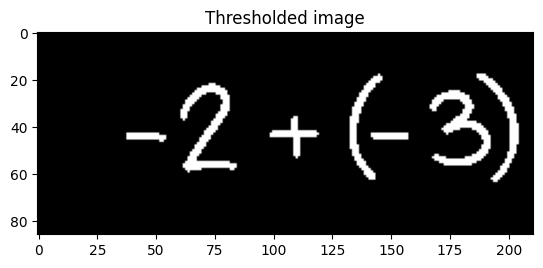

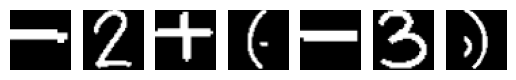

0: 0.00
1: 0.01
2: 0.00
3: 0.07
4: 0.01
5: 0.79
6: 0.00
7: 0.01
8: 0.01
9: 0.00
10: 0.00
11: 0.00
12: 0.00
13: 0.00
14: 0.00
15: 0.00
16: 0.00
17: 0.03
18: 0.00
19: 0.01
20: 0.00
21: 0.00
22: 0.01
23: 0.07
24: 0.00
25: 0.01
26: 0.00


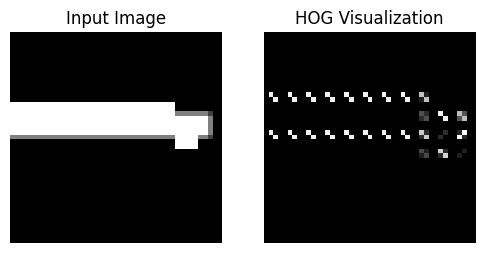

0: 0.04
1: 0.08
2: 0.04
3: 0.05
4: 0.05
5: 0.01
6: 0.01
7: 0.17
8: 0.25
9: 0.02
10: 0.01
11: 0.01
12: 0.01
13: 0.01
14: 0.01
15: 0.01
16: 0.01
17: 0.00
18: 0.01
19: 0.11
20: 0.00
21: 0.01
22: 0.01
23: 0.02
24: 0.04
25: 0.00
26: 0.01


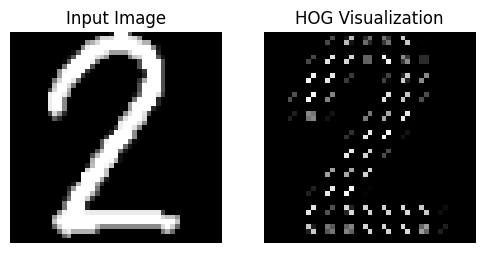

0: 0.00
1: 0.00
2: 0.01
3: 0.85
4: 0.01
5: 0.00
6: 0.01
7: 0.03
8: 0.01
9: 0.01
10: 0.03
11: 0.00
12: 0.00
13: 0.01
14: 0.01
15: 0.00
16: 0.01
17: 0.00
18: 0.01
19: 0.01
20: 0.00
21: 0.01
22: 0.01
23: 0.01
24: 0.00
25: 0.00
26: 0.00


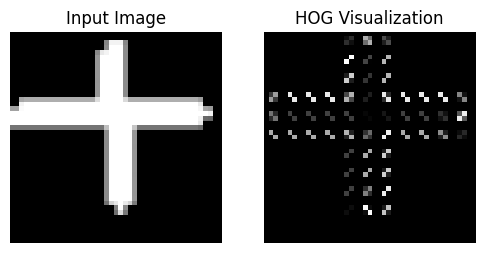

0: 0.04
1: 0.22
2: 0.01
3: 0.16
4: 0.04
5: 0.00
6: 0.01
7: 0.18
8: 0.01
9: 0.03
10: 0.10
11: 0.01
12: 0.07
13: 0.01
14: 0.01
15: 0.01
16: 0.01
17: 0.00
18: 0.01
19: 0.07
20: 0.00
21: 0.00
22: 0.00
23: 0.01
24: 0.00
25: 0.00
26: 0.00


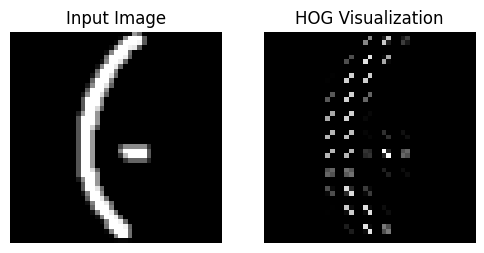

0: 0.00
1: 0.00
2: 0.00
3: 0.02
4: 0.00
5: 0.82
6: 0.00
7: 0.00
8: 0.02
9: 0.00
10: 0.00
11: 0.00
12: 0.00
13: 0.00
14: 0.00
15: 0.00
16: 0.00
17: 0.01
18: 0.00
19: 0.00
20: 0.00
21: 0.00
22: 0.01
23: 0.12
24: 0.00
25: 0.01
26: 0.00


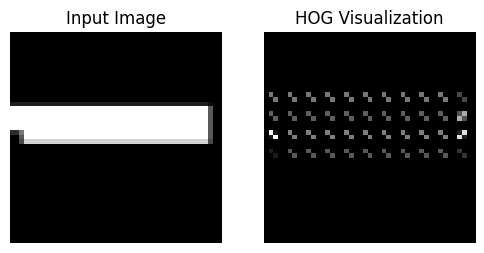

0: 0.01
1: 0.00
2: 0.01
3: 0.04
4: 0.00
5: 0.01
6: 0.04
7: 0.06
8: 0.07
9: 0.39
10: 0.04
11: 0.07
12: 0.02
13: 0.01
14: 0.01
15: 0.11
16: 0.01
17: 0.00
18: 0.04
19: 0.01
20: 0.02
21: 0.01
22: 0.01
23: 0.01
24: 0.02
25: 0.01
26: 0.00


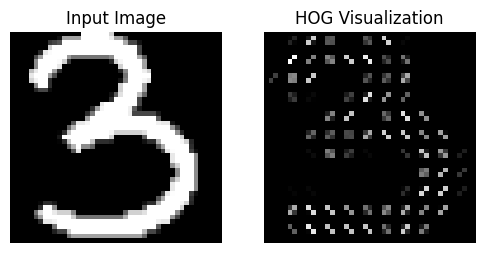

0: 0.03
1: 0.04
2: 0.30
3: 0.10
4: 0.07
5: 0.00
6: 0.01
7: 0.23
8: 0.04
9: 0.03
10: 0.03
11: 0.01
12: 0.01
13: 0.01
14: 0.01
15: 0.01
16: 0.01
17: 0.00
18: 0.00
19: 0.07
20: 0.01
21: 0.01
22: 0.00
23: 0.01
24: 0.01
25: 0.00
26: 0.00


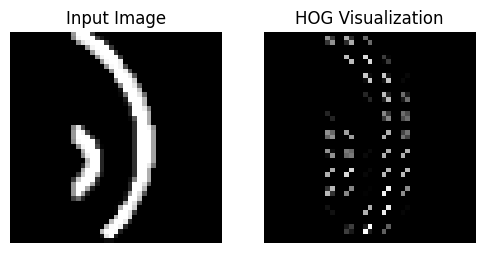

Recognized expression: -2+(-3)
Result: -5.00000000000000


In [74]:
# Example: feed an image
expr_img = "test_images/math.png"

expr_str = classify_expression(expr_img)
print("Recognized expression:", expr_str)

result = solving(expr_str)
print("Result:", result)

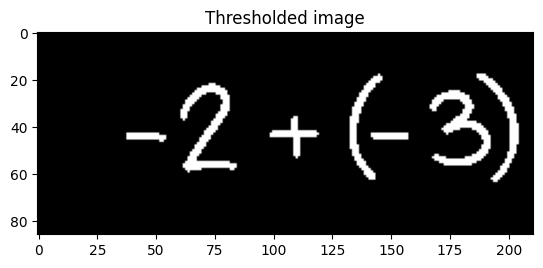

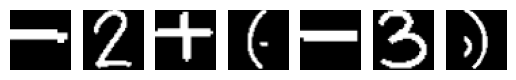

0: 0.00
1: 0.01
2: 0.00
3: 0.07
4: 0.01
5: 0.79
6: 0.00
7: 0.01
8: 0.01
9: 0.00
10: 0.00
11: 0.00
12: 0.00
13: 0.00
14: 0.00
15: 0.00
16: 0.00
17: 0.03
18: 0.00
19: 0.01
20: 0.00
21: 0.00
22: 0.01
23: 0.07
24: 0.00
25: 0.01
26: 0.00


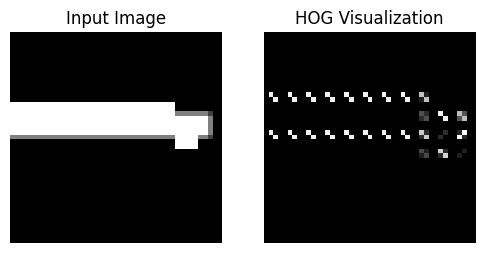

0: 0.04
1: 0.08
2: 0.04
3: 0.05
4: 0.05
5: 0.01
6: 0.01
7: 0.17
8: 0.25
9: 0.02
10: 0.01
11: 0.01
12: 0.01
13: 0.01
14: 0.01
15: 0.01
16: 0.01
17: 0.00
18: 0.01
19: 0.11
20: 0.00
21: 0.01
22: 0.01
23: 0.02
24: 0.04
25: 0.00
26: 0.01


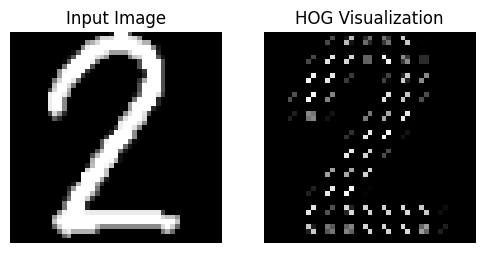

0: 0.00
1: 0.00
2: 0.01
3: 0.85
4: 0.01
5: 0.00
6: 0.01
7: 0.03
8: 0.01
9: 0.01
10: 0.03
11: 0.00
12: 0.00
13: 0.01
14: 0.01
15: 0.00
16: 0.01
17: 0.00
18: 0.01
19: 0.01
20: 0.00
21: 0.01
22: 0.01
23: 0.01
24: 0.00
25: 0.00
26: 0.00


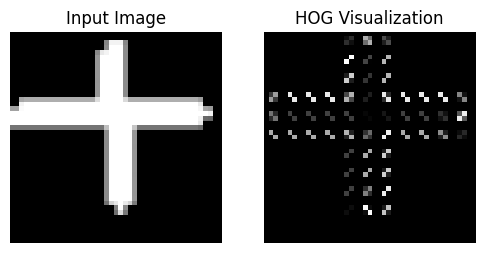

0: 0.04
1: 0.22
2: 0.01
3: 0.16
4: 0.04
5: 0.00
6: 0.01
7: 0.18
8: 0.01
9: 0.03
10: 0.10
11: 0.01
12: 0.07
13: 0.01
14: 0.01
15: 0.01
16: 0.01
17: 0.00
18: 0.01
19: 0.07
20: 0.00
21: 0.00
22: 0.00
23: 0.01
24: 0.00
25: 0.00
26: 0.00


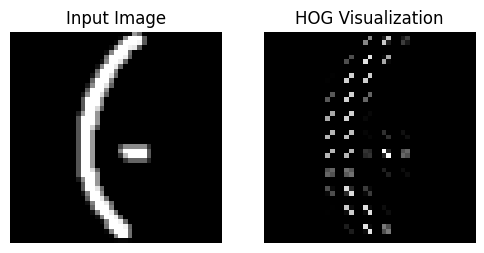

0: 0.00
1: 0.00
2: 0.00
3: 0.02
4: 0.00
5: 0.82
6: 0.00
7: 0.00
8: 0.02
9: 0.00
10: 0.00
11: 0.00
12: 0.00
13: 0.00
14: 0.00
15: 0.00
16: 0.00
17: 0.01
18: 0.00
19: 0.00
20: 0.00
21: 0.00
22: 0.01
23: 0.12
24: 0.00
25: 0.01
26: 0.00


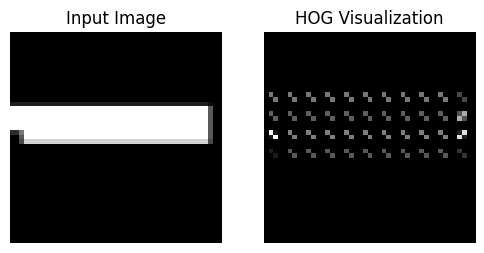

0: 0.01
1: 0.00
2: 0.01
3: 0.04
4: 0.00
5: 0.01
6: 0.04
7: 0.06
8: 0.07
9: 0.39
10: 0.04
11: 0.07
12: 0.02
13: 0.01
14: 0.01
15: 0.11
16: 0.01
17: 0.00
18: 0.04
19: 0.01
20: 0.02
21: 0.01
22: 0.01
23: 0.01
24: 0.02
25: 0.01
26: 0.00


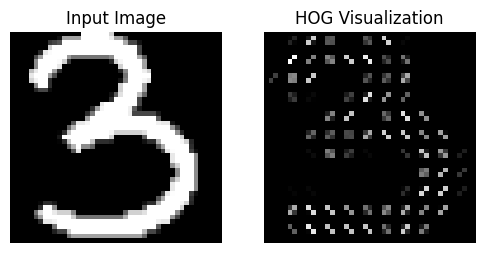

0: 0.03
1: 0.04
2: 0.30
3: 0.10
4: 0.07
5: 0.00
6: 0.01
7: 0.23
8: 0.04
9: 0.03
10: 0.03
11: 0.01
12: 0.01
13: 0.01
14: 0.01
15: 0.01
16: 0.01
17: 0.00
18: 0.00
19: 0.07
20: 0.01
21: 0.01
22: 0.00
23: 0.01
24: 0.01
25: 0.00
26: 0.00


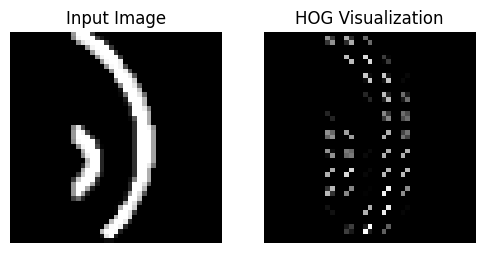

Recognized expression: -2+(-3)
Result: -5.00000000000000


In [75]:
expr_img = "test_images/math.png"

expr_str = classify_expression(expr_img)
print("Recognized expression:", expr_str)

result = solving(expr_str)
print("Result:", result)

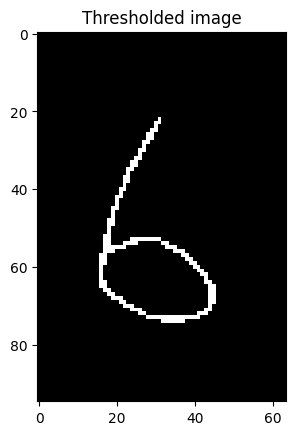

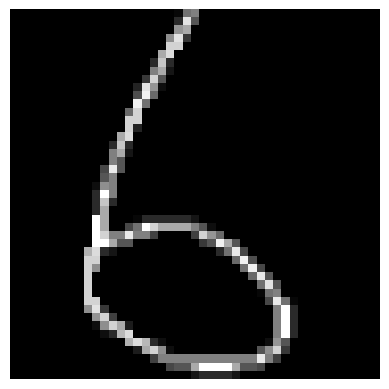

0: 0.06
1: 0.18
2: 0.01
3: 0.10
4: 0.04
5: 0.03
6: 0.01
7: 0.08
8: 0.09
9: 0.02
10: 0.06
11: 0.03
12: 0.07
13: 0.01
14: 0.00
15: 0.00
16: 0.01
17: 0.00
18: 0.01
19: 0.18
20: 0.00
21: 0.01
22: 0.00
23: 0.01
24: 0.01
25: 0.00
26: 0.00


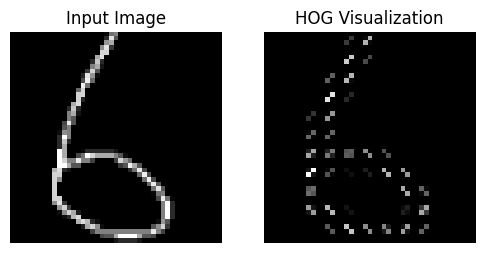

Recognized expression: (
Result: Error: Sympify of expression 'could not parse '('' failed, because of exception being raised:
TokenError: ('unexpected EOF in multi-line statement', (1, 0))


In [76]:
expr_img = "test_images/math3.png"

expr_str = classify_expression(expr_img)
print("Recognized expression:", expr_str)

result = solving(expr_str)
print("Result:", result)